# Creation of Model for Deployment

In [ ]:
!pip install ucimlrepo matplotlib seaborn pandas numpy kagglehub scikit-learn tensorflow joblib graphviz pydot

In [ ]:
# === General Libraries ===
import warnings, os, math, shutil, json, joblib
# from IPython.display import Markdown, display
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import kagglehub

# === Data Preprocessing ===
from sklearn.preprocessing import StandardScaler, OneHotEncoder # , OrdinalEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# === Evaluation Metrics ===
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, # f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    # mean_squared_error, r2_score, mean_absolute_error,
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score # , auc
)

# === TensorFlow / Keras ===
import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization,
    # Input, Flatten, Embedding, Concatenate, Reshape,
    LeakyReLU
)
# from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

c:\Users\JonathanChackoPattas\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
# fetch dataset
try:
    census_income = fetch_ucirepo(id=20) # https://archive.ics.uci.edu/dataset/20/census+income
    df = pd.concat([census_income.data.features, census_income.data.targets], axis=1)
except Exception as e:
    # print(f"Error fetching dataset from UCI repository: {e}")
    path = kagglehub.dataset_download("uciml/adult-census-income")
    df = pd.read_csv(os.path.join(path, "adult.csv"))
    df.columns = [col.replace('.', '-') for col in df.columns]
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [27]:
df.shape

(32561, 15)

In [28]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [29]:
df.isnull().sum() # check for null values

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [30]:
# Showing the Values in Each Column
for col in df.columns:
    print(f"Column: `{col}`")
    print(df[col].unique())
    print("\n")

Column: `age`
[90 82 66 54 41 34 38 74 68 45 52 32 51 46 57 22 37 29 61 21 33 49 23 59
 60 63 53 44 43 71 48 73 67 40 50 42 39 55 47 31 58 62 36 72 78 83 26 70
 27 35 81 65 25 28 56 69 20 30 24 64 75 19 77 80 18 17 76 79 88 84 85 86
 87]


Column: `workclass`
['?' 'Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Local-gov' 'Without-pay' 'Never-worked']


Column: `fnlwgt`
[ 77053 132870 186061 ...  34066  84661 257302]


Column: `education`
['HS-grad' 'Some-college' '7th-8th' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-acdm' 'Assoc-voc' '1st-4th' '5th-6th'
 '12th' '9th' 'Preschool']


Column: `education-num`
[ 9 10  4  6 16 15 13 14  7 12 11  2  3  8  5  1]


Column: `marital-status`
['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent' 'Married-AF-spouse']


Column: `occupation`
['?' 'Exec-managerial' 'Machine-op-inspct' 'Prof-specialty'
 'Other-service' 'Adm-clerical' 'Craft-repair' 'Transport-m

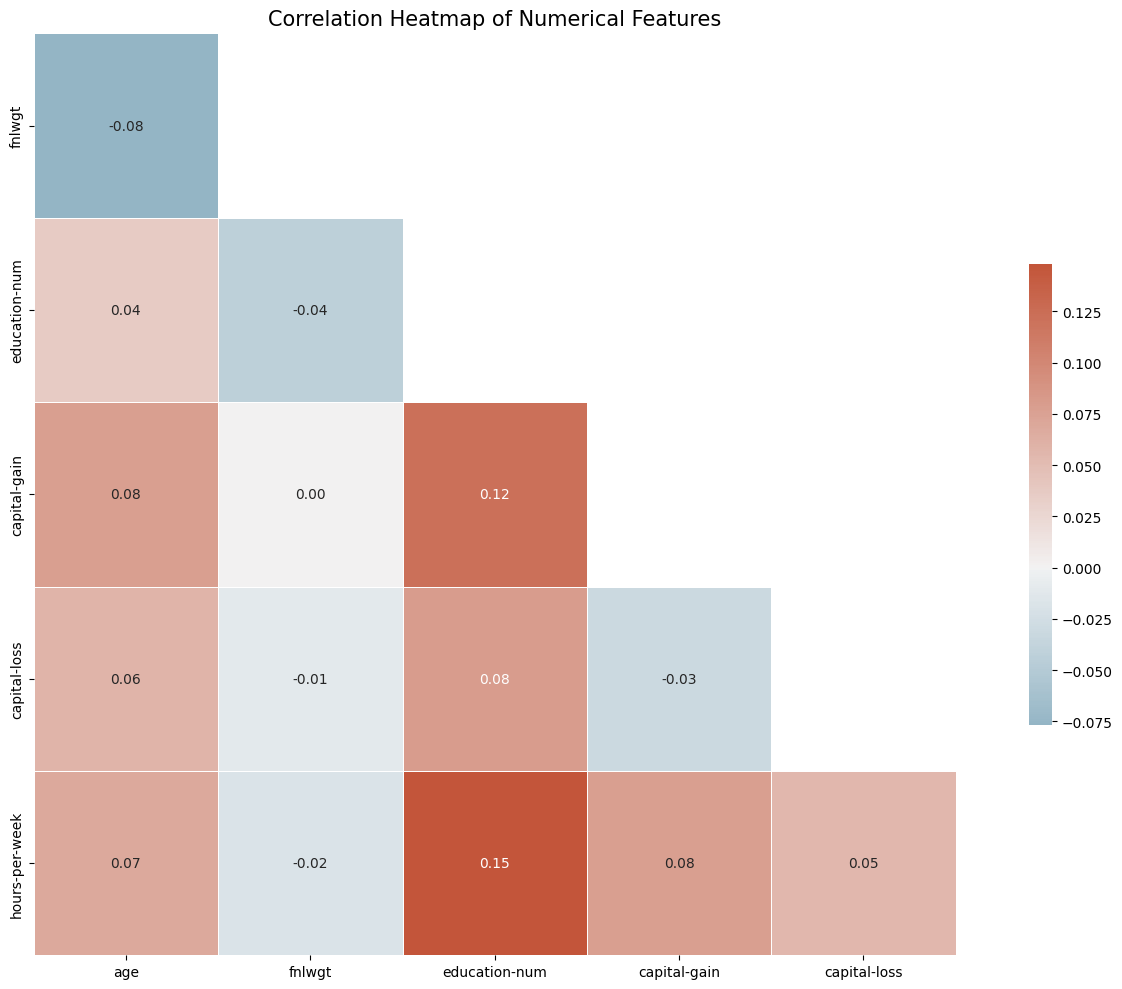

In [31]:
numeric_df = df.select_dtypes(include=['int64', 'float64']) # Create a copy of the dataframe with only numeric columns
corr_matrix = numeric_df.corr() # Compute correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Apply mask
corr_matrix_trimmed = corr_matrix.iloc[1:, :-1]
mask_trimmed = mask[1:, :-1]
plt.figure(figsize=(15, 10))# Plot heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    corr_matrix_trimmed,
    mask=mask_trimmed,
    annot=True,
    fmt='.2f',
    cmap=cmap,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.5}
)
plt.title('Correlation Heatmap of Numerical Features', fontsize=15)
plt.tight_layout()
plt.show()

In [32]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [33]:
# 1. Handling missing values (replacing `'?'` with `NaN` and dropping rows)
df[df=='?']=np.nan # Replacing '?' with NaN
df=df.dropna(axis=0) # Dropping all rows with NaN values
# df = df[~(df['native-country'] == "?") | (df['native-country'].isnull())] # ALTERNATIVE Removing all rows with Unknown Countries as part of data cleaning process

In [34]:
# 2. Transforming categorical variables (age binning)
df['age'] = pd.cut(df['age'], bins=[0, 30, 60, 100], labels=['Young', 'Middle-aged', 'Old']) # .astype('category')

C:\Users\JonathanChackoPattas\AppData\Local\Temp\ipykernel_63508\1335194867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'] = pd.cut(df['age'], bins=[0, 30, 60, 100], labels=['Young', 'Middle-aged', 'Old']) # .astype('category')


In [35]:
# 3. Feature engineering (creating capital-profit from gain/loss)
df['capital-metrics'] = df['capital-gain'] - df['capital-loss']
df['capital-profit'] = df['capital-metrics'].apply(lambda x: 0 if x < 0 else 1)
df.drop(columns=['capital-gain', 'capital-loss', 'capital-metrics'], inplace=True)

C:\Users\JonathanChackoPattas\AppData\Local\Temp\ipykernel_63508\2113602367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['capital-metrics'] = df['capital-gain'] - df['capital-loss']
C:\Users\JonathanChackoPattas\AppData\Local\Temp\ipykernel_63508\2113602367.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['capital-profit'] = df['capital-metrics'].apply(lambda x: 0 if x < 0 else 1)
C:\Users\JonathanChackoPattas\AppData\Local\Temp\ipykernel_63508\2113602367.py:4: SettingWithCopyWarning: 
A val

In [36]:
df.info() # check the data types and null values

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 1 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             30162 non-null  category
 1   workclass       30162 non-null  object  
 2   fnlwgt          30162 non-null  int64   
 3   education       30162 non-null  object  
 4   education-num   30162 non-null  int64   
 5   marital-status  30162 non-null  object  
 6   occupation      30162 non-null  object  
 7   relationship    30162 non-null  object  
 8   race            30162 non-null  object  
 9   sex             30162 non-null  object  
 10  hours-per-week  30162 non-null  int64   
 11  native-country  30162 non-null  object  
 12  income          30162 non-null  object  
 13  capital-profit  30162 non-null  int64   
dtypes: category(1), int64(4), object(9)
memory usage: 3.3+ MB


In [37]:
# 4. Removing irrelevant features
df.drop(columns=['fnlwgt', 'education'], inplace=True) # Dropping the fnlwgt and education columns as they are not relevant to the analysis
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

C:\Users\JonathanChackoPattas\AppData\Local\Temp\ipykernel_63508\3478189207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['fnlwgt', 'education'], inplace=True) # Dropping the fnlwgt and education columns as they are not relevant to the analysis
C:\Users\JonathanChackoPattas\AppData\Local\Temp\ipykernel_63508\3478189207.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [38]:
# 5. Standardizing the target variable
df['income'] = df['income'].str.replace('.', '')
df['income'].replace({'<=50K': 0, '>50K': 1}, inplace=True)
# df['income'] = df['income'].astype('category')
df['income'].value_counts()

C:\Users\JonathanChackoPattas\AppData\Local\Temp\ipykernel_63508\2564686886.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['income'].replace({'<=50K': 0, '>50K': 1}, inplace=True)
C:\Users\JonathanChackoPattas\AppData\Local\Temp\ipykernel_63508\2564686886.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcas

income
0    22654
1     7508
Name: count, dtype: int64

In [39]:
# Separate features
numerical_features_temp = df.select_dtypes(include=['int64', 'float64']).drop(columns=['income', 'capital-profit']).columns.tolist()
categorical_features_temp = df.select_dtypes(include=['object', 'category']).columns.tolist()

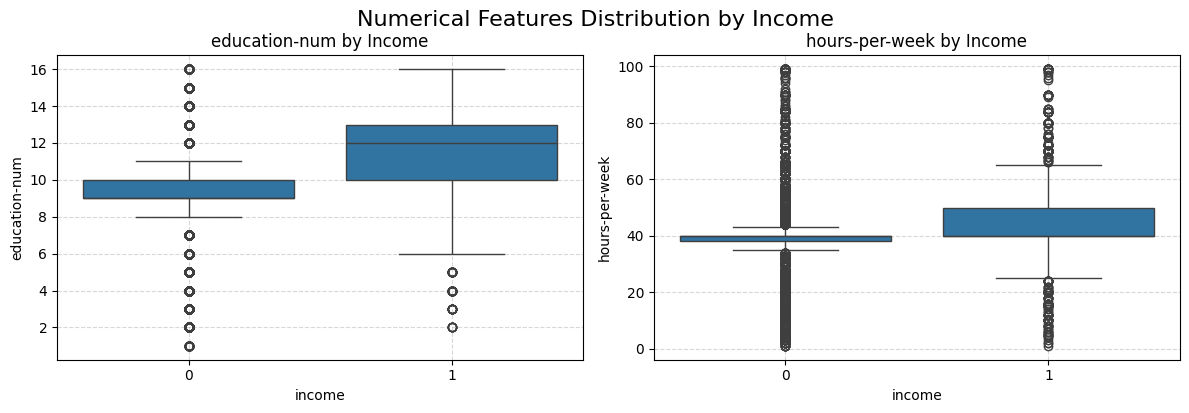

In [40]:
# === NUMERICAL FEATURES ===
num_cols = 2
num_rows = math.ceil(len(numerical_features_temp) / num_cols)
plt.figure(figsize=(num_cols * 6, num_rows * 4))

for i, feature in enumerate(numerical_features_temp):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(data=df, x='income', y=feature)
    plt.title(f"{feature} by Income")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

plt.suptitle("Numerical Features Distribution by Income", y=1.02, fontsize=16)
plt.show()

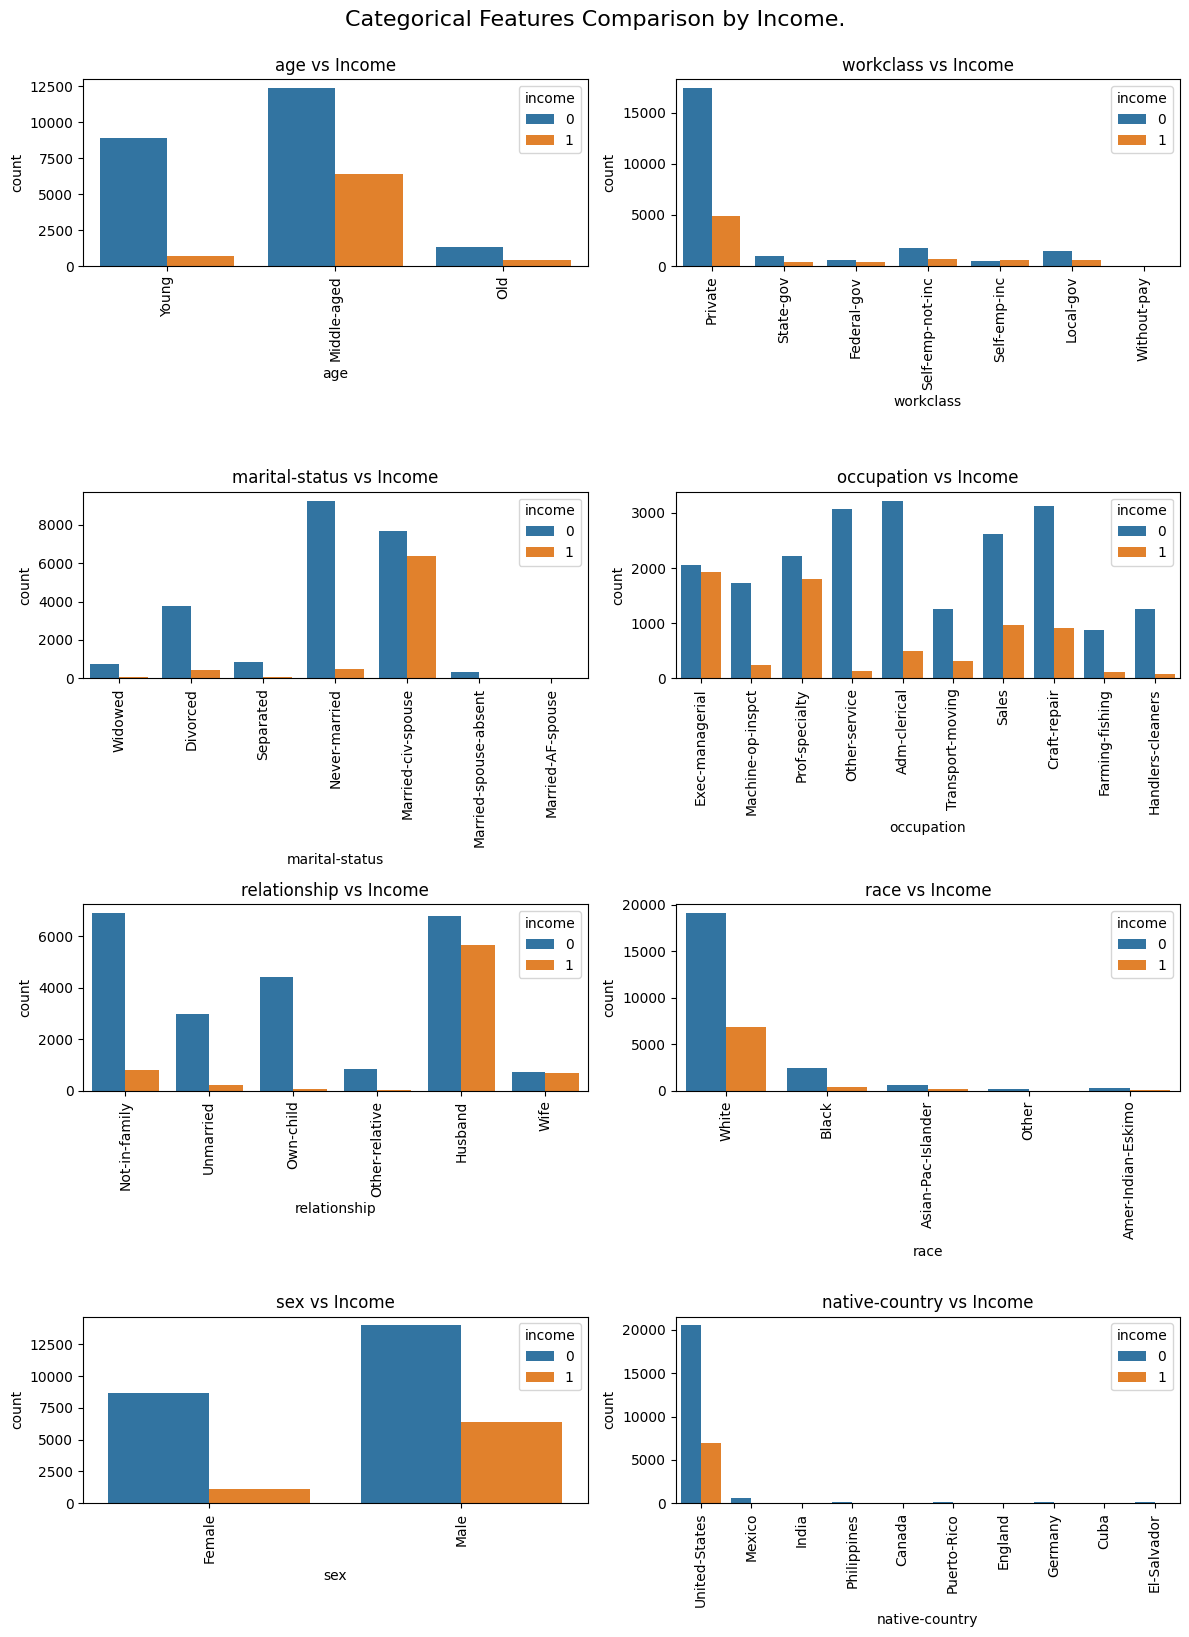

In [41]:
# === CATEGORICAL FEATURES ===
cat_cols = 2
cat_rows = math.ceil(len(categorical_features_temp) / cat_cols)
plt.figure(figsize=(cat_cols * 6, cat_rows * 4))

for i, feature in enumerate(categorical_features_temp):
    plt.subplot(cat_rows, cat_cols, i + 1)

    # Get top 10 most common categories (if needed)
    top_categories = df[feature].value_counts().nlargest(10).index
    filtered_df = df[df[feature].isin(top_categories)]

    sns.countplot(data=filtered_df, x=feature, hue='income')
    plt.title(f"{feature} vs Income")
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.suptitle("Categorical Features Comparison by Income.", y=1.02, fontsize=16)
plt.show()

In [47]:
values_dict = {}
for col in df.columns:
    values_dict[col] = list(df[col].value_counts().keys())
print(json.dumps(values_dict, indent=2))

{
  "age": [
    "Middle-aged",
    "Young",
    "Old"
  ],
  "workclass": [
    "Private",
    "Self-emp-not-inc",
    "Local-gov",
    "State-gov",
    "Self-emp-inc",
    "Federal-gov",
    "Without-pay"
  ],
  "education-num": [
    9,
    10,
    13,
    14,
    11,
    7,
    12,
    6,
    4,
    15,
    5,
    8,
    16,
    3,
    2,
    1
  ],
  "marital-status": [
    "Married-civ-spouse",
    "Never-married",
    "Divorced",
    "Separated",
    "Widowed",
    "Married-spouse-absent",
    "Married-AF-spouse"
  ],
  "occupation": [
    "Prof-specialty",
    "Craft-repair",
    "Exec-managerial",
    "Adm-clerical",
    "Sales",
    "Other-service",
    "Machine-op-inspct",
    "Transport-moving",
    "Handlers-cleaners",
    "Farming-fishing",
    "Tech-support",
    "Protective-serv",
    "Priv-house-serv",
    "Armed-Forces"
  ],
  "relationship": [
    "Husband",
    "Not-in-family",
    "Own-child",
    "Unmarried",
    "Wife",
    "Other-relative"
  ],
  "race": [
    "

In [48]:
df.columns

Index(['age', 'workclass', 'education-num', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'hours-per-week', 'native-country',
       'income', 'capital-profit'],
      dtype='object')

In [ ]:
target = 'income' # Setting the target variable

# Create preprocessing pipelines for numerical and categorical data
numeric_features = [f for f in df.select_dtypes(include=[np.number, 'number', 'float64', 'int64', 'float32', 'int32']).columns.to_list() if f != target]
categorical_features = [f for f in df.select_dtypes(include=["object", "category"]).columns.to_list() if f != target ]

# Numeric pipeline with standard scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# Categorical pipeline with one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(
        # drop='first',
        # sparse_output=False, # Return dense array
        handle_unknown="ignore"
    )),
    # ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [ ]:
# Create X and y
X = df.drop(columns=[target])
y = df[target]

In [ ]:
# First split: separate out the test set (80% train+val, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Verify the split proportions
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/X.shape[0]:.2%} of total)")

In [ ]:
# Check class distribution in each set
print(f"\nClass distribution:")
print(f"Overall: {y.value_counts(normalize=True).to_dict()}")
print(f"Test: {y_test.value_counts(normalize=True).to_dict()}")

In [ ]:
# Check class distribution in the dataset
class_distribution = y.value_counts(normalize=True)
plt.figure(figsize=(15, 10)) # Create a bar plot of the class distribution
ax = sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution in Dataset')
plt.xlabel('Income Group (0: ≤$50K, 1: >$50K)')
plt.ylabel('Proportion')
for i, p in enumerate(ax.patches): # Add percentage labels on top of the bars
    height = p.get_height()
    ax.annotate(f'{height:.1%}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print(r"Class distribution in dataset:")
class_distribution

In [ ]:
# Dynamic Interpretation
def interpret_dataset_class_distribution(class_distribution):
    interpretation = []
    interpretation.append("Class Distribution in Full Dataset")
    # Ensure it's a dictionary
    if hasattr(class_distribution, 'to_dict'):
        class_distribution = class_distribution.to_dict()
    for cls, proportion in class_distribution.items():
        interpretation.append(f"- Class {cls}: {proportion:.1%} of total samples")
    majority_class = max(class_distribution, key=class_distribution.get)
    minority_class = min(class_distribution, key=class_distribution.get)
    majority_ratio = class_distribution[majority_class]
    minority_ratio = class_distribution[minority_class]
    imbalance_ratio = majority_ratio / minority_ratio
    interpretation.append(f"\n- Imbalance ratio (majority:minority) => {imbalance_ratio:.2f}:1")
    if imbalance_ratio > 1.5:
        interpretation.append("\nThere is a significant class imbalance in the dataset.")
        interpretation.append("Without corrective measures, the model may favor the majority class.")
        interpretation.append("To address this, techniques like class weighting, resampling, or threshold tuning are recommended.")
    else:
        interpretation.append("\nThe dataset is relatively balanced, so class imbalance should not heavily impact performance.")
    return "\n".join(interpretation)
print(interpret_dataset_class_distribution(class_distribution))

In [ ]:
# Since our dataset has an imbalance we'll calculate class weights to ensure the model pays sufficient attention to the minority class during training.
y_train_series = pd.Series(y_train)
class_counts = y_train_series.value_counts().sort_index()
classes = np.array(class_counts.index)  # instead of .to_list()
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_series)
class_weight_dict = dict(zip(classes, weights))
# class_weight_dict = {i: weight for i, weight in enumerate(len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train)))}
print(r"Class weights for model training:")
print(json.dumps({int(key):float(value) for key, value in class_weight_dict.items()}, indent=4))

In [ ]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# Plot 1: Class Distribution
sns.barplot(x=class_counts.index, y=class_counts.values, ax=ax[0])
ax[0].set_title('Class Distribution in y_train')
ax[0].set_xlabel('Class Label')
ax[0].set_ylabel('Number of Samples')
# Plot 2: Computed Class Weights
sns.barplot(x=list(class_weight_dict.keys()), y=list(class_weight_dict.values()), ax=ax[1], palette="mako")
ax[1].set_title('Computed Class Weights')
ax[1].set_xlabel('Class Label')
ax[1].set_ylabel('Weight Value')
plt.tight_layout()
plt.show()

In [ ]:
# Dynamic Interpretation
def interpret_class_weights(class_counts, class_weight_dict):
    interpretation = []
    interpretation.append("Class Distribution and Computed Weights Interpretation")
    # Convert to dictionary if it's a pandas Series
    if hasattr(class_counts, 'to_dict'):
        class_counts = class_counts.to_dict()
    total_samples = sum(class_counts.values())
    majority_class = max(class_counts, key=class_counts.get)
    minority_class = min(class_counts, key=class_counts.get)
    majority_count = class_counts[majority_class]
    minority_count = class_counts[minority_class]
    interpretation.append(f"- Total training samples: {total_samples}")
    interpretation.append(f"- Class {majority_class} has {majority_count} samples.")
    interpretation.append(f"- Class {minority_class} has {minority_count} samples.")
    imbalance_ratio = majority_count / minority_count
    interpretation.append(f"- Class imbalance ratio (majority/minority): {imbalance_ratio:.2f}")
    interpretation.append("\nComputed Class Weights:")
    for cls, weight in class_weight_dict.items():
        interpretation.append(f"- Class {cls}: Weight = {weight:.2f}")
    if imbalance_ratio > 1.5:
        interpretation.append("\nThe dataset is imbalanced. The Variable `class_weight_dict` is used to address this by giving more importance to the minority class during training.")
        interpretation.append("This encourages the model to pay equal attention to both classes by increasing the penalty for misclassifying underrepresented samples.")
        interpretation.append("As a result, class_weight helps the model avoid biasing predictions toward the majority class.")
    else:
        interpretation.append("\nThe class distribution is relatively balanced, so class weights may have limited effect.")
    return "\n".join(interpretation)
print(interpret_class_weights(class_counts, class_weight_dict))

In [ ]:
# Initialize lists to store metrics and models
fold_metrics = []
fold_models = []

best_metric = -np.inf  # Initialize to very low number
best_fold_idx_number = -1
# best_model = None

folder_path = "ignore/fold_models" # os.makedirs("ignore/fold_models", exist_ok=True)

# If the folder exists, empty it
if os.path.exists(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # remove file or link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # remove subdirectory
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')
else:
    os.makedirs(folder_path)  # create the folder if it doesn't exist


fold_historys = {}

# Configuration based on seeking high robustness and accuracy, ignoring time constraints:
number_of_folds = 10  # Use 10 folds for a robust cross-validation estimate of performance.
number_of_epochs = 300 # Set epochs high; this will be controlled by early stopping.

# KFold CV
kf = KFold(n_splits=number_of_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f'\nFold {fold + 1}/{number_of_folds}')
    checkpoint_path = f'{folder_path}/fold_{fold + 1}.keras'

    # Train/Val Split
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Preprocessing
    X_fold_train_processed = preprocessor.fit_transform(X_fold_train).astype('float32')
    X_fold_val_processed = preprocessor.transform(X_fold_val).astype('float32')
    # X_test_processed = preprocessor.transform(X_test).astype('float32')

    # Model
    input_dim = X_fold_train_processed.shape[1]
    keras_model = Sequential([
        # Input-level dropout to add noise and prevent overfitting from the start
        Dropout(0.1, input_shape=(input_dim,)),

        # First Dense layer with He initialization (good for ReLU/LeakyReLU)
        # Followed by LeakyReLU to avoid dead neuron problems
        Dense(256, kernel_initializer='he_normal'),
        LeakyReLU(alpha=0.1),  # Allows small gradients when input < 0
        BatchNormalization(),  # Normalize activations to improve convergence
        Dropout(0.3),          # Dropout to reduce overfitting

        # Second Dense layer with ReLU activation
        # BatchNorm and Dropout help regularize this layer
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Third Dense layer, similar structure
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer for binary classification (sigmoid outputs probability)
        Dense(1, activation='sigmoid')
    ])

    keras_model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
    )
    
    early_stopping = EarlyStopping(
        monitor='val_auc',
        patience=15,
        min_delta=0.001,  # minimum improvement threshold
        mode='max',
        restore_best_weights=True,
        verbose=1
    )

    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_auc',  # track AUC for model selection
        mode='max',
        save_best_only=True,
        verbose=0
    )

    history = keras_model.fit(
        X_fold_train_processed, y_fold_train,
        validation_data=(X_fold_val_processed, y_fold_val),
        epochs=number_of_epochs,
        batch_size=64,
        class_weight=class_weight_dict,
        callbacks=[early_stopping, model_checkpoint], # Save the best model based on AUC
        verbose=0,
        shuffle=True # Shuffle the training data for each epoch
    )

    fold_historys[fold + 1] = history.history

    # Evaluation
    _, accuracy, precision, recall, auc = keras_model.evaluate(X_fold_val_processed, y_fold_val, verbose=0)
    
    # Store results
    fold_metrics.append({
        'fold': fold + 1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'auc': auc
    })
    
    fold_models.append(keras_model)

    print(f'Fold {fold + 1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}')

    # Track best model by AUC
    if auc > best_metric:
        best_metric = auc
        # best_model = keras_model
        best_fold_idx_number = fold + 1

In [ ]:
def compute_f1(precision, recall):
    return [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

for fold_num, history in fold_historys.items():
    print(f"Fold {fold_num} Training History")

    fig = plt.figure(figsize=(15, 15), constrained_layout=True)
    gs = fig.add_gridspec(4, 2)

    # Subplots for rows 1 to 3
    ax_accuracy = fig.add_subplot(gs[0, 0])
    ax_loss = fig.add_subplot(gs[0, 1])
    ax_precision = fig.add_subplot(gs[1, 0])
    ax_recall = fig.add_subplot(gs[1, 1])
    ax_auc = fig.add_subplot(gs[2, 0])
    ax_f1 = fig.add_subplot(gs[2, 1])
    # ax_gap = fig.add_subplot(gs[3, 0])      # ← Row 4 (AUC Gap) - Commented
    # ax_lr = fig.add_subplot(gs[3, 1])       # ← Row 4 (Learning Rate) - Commented

    # Standard metric plots
    base_metrics = [
        ('accuracy', ax_accuracy),
        ('loss', ax_loss),
        ('precision', ax_precision),
        ('recall', ax_recall),
        ('auc', ax_auc),
    ]

    for metric, ax in base_metrics:
        ax.plot(history[metric], label='Train', linewidth=2)
        ax.plot(history[f'val_{metric}'], label='Validation', linestyle='--', linewidth=2)
        ax.set_title(f'{metric.title()}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.title())
        ax.legend()
        ax.grid(True)

    # F1 Score plot
    train_f1 = compute_f1(history['precision'], history['recall'])
    val_f1 = compute_f1(history['val_precision'], history['val_recall'])
    ax_f1.plot(train_f1, label='Train F1', linewidth=2)
    ax_f1.plot(val_f1, label='Val F1', linestyle='--', linewidth=2)
    ax_f1.set_title('F1 Score')
    ax_f1.set_xlabel('Epoch')
    ax_f1.set_ylabel('F1 Score')
    ax_f1.legend()
    ax_f1.grid(True)

    # AUC Gap Plot
    # auc_gap = [tr - val for tr, val in zip(history['auc'], history['val_auc'])]
    # ax_gap.plot(auc_gap, color='orange', label='AUC Gap (Train - Val)', linewidth=2)
    # ax_gap.axhline(0, color='gray', linestyle='--')
    # ax_gap.set_title('AUC Gap')
    # ax_gap.set_xlabel('Epoch')
    # ax_gap.set_ylabel('Gap')
    # ax_gap.legend()
    # ax_gap.grid(True)

    # Learning Rate Plot
    # if 'lr' in history:
    #     ax_lr.plot(history['lr'], label='Learning Rate', color='purple', linewidth=2)
    #     ax_lr.set_title('Learning Rate')
    #     ax_lr.set_xlabel('Epoch')
    #     ax_lr.set_ylabel('LR')
    #     ax_lr.legend()
    #     ax_lr.grid(True)
    # else:
    #     ax_lr.text(0.5, 0.5, 'No LR Data', ha='center', va='center', fontsize=12)
    #     ax_lr.set_title('Learning Rate')
    #     ax_lr.axis('off')

    fig.suptitle(f'Fold {fold_num} - Training Metrics', fontsize=18, fontweight='bold')
    plt.show()

In [ ]:
# Average metrics
avg_metrics = {
    metric: np.mean([fold[metric] for fold in fold_metrics])
    for metric in ['accuracy', 'precision', 'recall', 'auc']
}

print('\nAverage metrics across all folds:')
print(f"Accuracy: {avg_metrics['accuracy']:.4f}")
print(f"Precision: {avg_metrics['precision']:.4f}")
print(f"Recall: {avg_metrics['recall']:.4f}")
print(f"AUC: {avg_metrics['auc']:.4f}")

In [ ]:
df_metrics = pd.DataFrame(fold_metrics) # Convert to DataFrame
plt.figure(figsize=(15, 10)) # Plotting
# df_metrics.plot(x='fold', y=['accuracy', 'precision', 'recall', 'auc'], kind='bar', figsize=(10, 5))
for metric in ['accuracy', 'precision', 'recall', 'auc']:
    plt.plot(df_metrics['fold'], df_metrics[metric], marker='o', label=metric)
plt.title('K-Fold Cross-Validation Metrics') # plt.title('Fold-wise Evaluation Metrics')
plt.axvline(best_fold_idx_number, color='red', linestyle='--', label=f'Best Fold ({best_fold_idx_number})')
plt.xlabel('Fold')
plt.ylabel('Score')
# plt.xticks(np.arange(len(df_metrics))) # plt.xticks(rotation=0)
plt.ylim(0.5, 1.0)
plt.grid(True) # plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Dynamic Interpretation
def interpret_kfold_metrics(df_metrics):
    interpretation = []
    interpretation.append("K-Fold Cross-Validation Metrics Summary")
    metrics = ['accuracy', 'precision', 'recall', 'auc']
    for metric in metrics:
        mean = df_metrics[metric].mean()
        std = df_metrics[metric].std()
        min_val = df_metrics[metric].min()
        max_val = df_metrics[metric].max()
        interpretation.append(f"\n{metric.capitalize()} Summary:")
        interpretation.append(f"- Mean: {mean:.4f}")
        interpretation.append(f"- Standard Deviation: {std:.4f}")
        interpretation.append(f"- Min: {min_val:.4f}, Max: {max_val:.4f}")
        if std < 0.015:
            interpretation.append("  The performance is highly consistent across folds.")
        elif std < 0.03:
            interpretation.append("  The model is reasonably stable across folds.")
        else:
            interpretation.append("  There is noticeable variation; fold-specific results should be reviewed.")
    return "\n".join(interpretation)
print(interpret_kfold_metrics(df_metrics))

In [ ]:
# Report best fold
print(f"\nBest Model is from Fold {best_fold_idx_number} with AUC: {best_metric:.4f}")
best_model_path = f'{folder_path}/fold_{best_fold_idx_number}.keras'
final_model = load_model(best_model_path)

In [ ]:
plot_model(
    final_model,
    to_file='ignore/model_plot.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

In [ ]:
final_model.summary()

In [ ]:
# Need for Deployment
script_dir = os.getcwd() # os.path.dirname(os.path.abspath(__file__)) # Get the directory of the current script
parent_dir = os.path.dirname(script_dir)
final_model.save(os.path.join(parent_dir, "artifacts", "model.keras"))  # Ensure 'model' is your trained Keras model
joblib.dump(preprocessor, os.path.join(parent_dir, "artifacts", "preprocessing_pipeline.pkl"))

In [ ]:
best_history = fold_historys[best_fold_idx_number - 1]
best_epoch_index = np.argmax(best_history['val_auc']) # Get metrics from best epoch

In [ ]:
plt.figure(figsize=(15, 10))
# # Accuracy curves
# plt.plot(best_history['accuracy'], label='Train Accuracy', color='blue')
# plt.plot(best_history['val_accuracy'], label='Validation Accuracy', color='blue', linestyle='--')
# # Loss curves (scaled to match accuracy axis)
# plt.plot(best_history['loss'], label='Train Loss', color='green')
# plt.plot(best_history['val_loss'], label='Validation Loss', color='green', linestyle='--')
# # Best epoch vertical line
# plt.axvline(best_epoch_index, color='red', linestyle='--', label=f'Best Epoch ({best_epoch_index})')
epochs = np.arange(len(best_history['accuracy']))
plt.subplot(1, 2, 1) # Plot training accuracy values
plt.plot(best_history['accuracy'], label='Train')
plt.plot(best_history['val_accuracy'], label='Validation')
plt.axvline(best_epoch_index + 1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch_index + 1})')
plt.xticks(epochs)  # Set x-axis ticks to every epoch
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.subplot(1, 2, 2) # Plot training loss values
plt.plot(best_history['loss'], label='Train')
plt.plot(best_history['val_loss'], label='Validation')
plt.axvline(best_epoch_index + 1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch_index + 1})')
plt.xticks(epochs)  # Set x-axis ticks to every epoch
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
# plt.title('Model Accuracy and Loss Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Metric Value')
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print information about training
print(f"Training completed after {len(best_history['loss'])} epochs")
print(f"Best epoch based on val AUC: {best_epoch_index + 1}")
print(f"Final training loss: {best_history['loss'][-1]:.4f}")
print(f"Final training accuracy: {best_history['accuracy'][-1]:.4f}")
print(f"Final validation loss: {best_history['val_loss'][-1]:.4f}")
print(f"Final validation accuracy: {best_history['val_accuracy'][-1]:.4f}")


In [ ]:
# Dynamic Interpetation
def interpret_learning_curves(history, best_epoch_index):
    interpretation = []
    interpretation.append("Training Curve Interpretation")
    num_epochs = len(history['loss'])
    final_train_acc = history['accuracy'][-1]
    final_val_acc = history['val_accuracy'][-1]
    final_train_loss = history['loss'][-1]
    final_val_loss = history['val_loss'][-1]
    interpretation.append(f"- Training completed over {num_epochs} epochs.")
    interpretation.append(f"- Final Training Accuracy: {final_train_acc:.4f}")
    interpretation.append(f"- Final Validation Accuracy: {final_val_acc:.4f}")
    interpretation.append(f"- Final Training Loss: {final_train_loss:.4f}")
    interpretation.append(f"- Final Validation Loss: {final_val_loss:.4f}")
    # Overfitting check
    if final_val_acc > final_train_acc and final_val_loss < final_train_loss:
        interpretation.append("\nThe validation accuracy is slightly higher than training accuracy, and validation loss is lower. This suggests that the model generalizes well.")
    elif final_val_acc < final_train_acc and final_val_loss > final_train_loss:
        interpretation.append("\nThere may be signs of overfitting, as validation accuracy is lower and validation loss is higher than training performance.")
    else:
        interpretation.append("\nTraining and validation curves appear fairly close, suggesting reasonable generalization.")
    interpretation.append(f"\nNOTE= Best epoch based on validation AUC: {best_epoch_index + 1}")
    return "\n".join(interpretation)
print(interpret_learning_curves(best_history, best_epoch_index))

In [ ]:
# Validation metrics at best epoch
val_accuracy = best_history['val_accuracy'][best_epoch_index]
val_precision = best_history['val_precision'][best_epoch_index]
val_recall = best_history['val_recall'][best_epoch_index]
val_auc = best_history['val_auc'][best_epoch_index]
val_loss = best_history['val_loss'][best_epoch_index]
# val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

print("Best Epoch Number is:", best_epoch_index + 1, "\nfrom Fold Number", best_fold_idx_number)

In [ ]:
# Preprocess the test set
X_test_processed = preprocessor.transform(X_test).astype('float32')
# Predict and evaluate
y_test_pred_probs = final_model.predict(X_test_processed).flatten()
y_test_pred = (y_test_pred_probs > 0.5).astype("int32") # Convert probabilities to binary predictions
y_test_pred

In [ ]:
test_loss = final_model.evaluate(X_test_processed, y_test, verbose=0)[0]
test_accuracy = accuracy_score(y_test, y_test_pred) # final_model.evaluate(X_test_processed, y_test, verbose=0)[1]
test_precision = precision_score(y_test, y_test_pred) # final_model.evaluate(X_test_processed, y_test, verbose=0)[2]
test_recall = recall_score(y_test, y_test_pred) # final_model.evaluate(X_test_processed, y_test, verbose=0)[3]
test_auc = roc_auc_score(y_test, y_test_pred_probs) # final_model.evaluate(X_test_processed, y_test, verbose=0)[4]
# test_f1 = f1_score(y_test, y_test_pred)

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
cr = classification_report(y_test, y_test_pred, output_dict=True)
cr_df = pd.DataFrame(cr).transpose()
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_probs)
average_precision = average_precision_score(y_test, y_test_pred_probs)

In [ ]:
metrics = {
    "Accuracy": {
        "VALIDATION": val_accuracy,
        "TEST": test_accuracy
    },
    "Precision": {
        "VALIDATION": val_precision,
        "TEST": test_precision
    },
    "Recall": {
        "VALIDATION": val_recall,
        "TEST": test_recall
    },
    "AUC": {
        "VALIDATION": val_auc,
        "TEST": test_auc
    },
    "Loss": {
        "VALIDATION": val_loss,
        "TEST": test_loss
    }
    # "F1": {
    #     "VALIDATION": val_f1,
    #     "TEST": test_f1
    # }
}
print(json.dumps(metrics, indent=4))

In [ ]:
# Extract values for plotting
metric_names = list(metrics.keys())
val_scores = [metrics[m]["VALIDATION"] for m in metric_names]
test_scores = [metrics[m]["TEST"] for m in metric_names]

# Positioning and bar plot setup
x = np.arange(len(metrics))
width = 0.35
plt.figure(figsize=(15, 10))
# Plotting the bars
bars1 = plt.bar(x - width/2, val_scores, width, label='Validation (Best Epoch)', color='skyblue')
bars2 = plt.bar(x + width/2, test_scores, width, label='Test Set', color='salmon')
# Plot customization
plt.ylabel('Score')
plt.title('Validation (Best Epoch) vs Test Performance')
plt.xticks(x, metrics)
plt.ylim(0, 1 if max(max(val_scores), max(test_scores)) <= 1 else max(max(val_scores), max(test_scores)) + 0.1)
plt.legend()
plt.grid(axis='y')
# Annotate bars with values
for i in range(len(metrics)):
    plt.text(x[i] - width/2, val_scores[i] + 0.01, f"{val_scores[i]:.2f}", ha='center', va='bottom')
    plt.text(x[i] + width/2, test_scores[i] + 0.01, f"{test_scores[i]:.2f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [ ]:
# Dynamic Interpretation
def generate_interpretation(metrics):
    interpretation = []
    interpretation.append("Validation vs Test Performance Interpretation =")
    for metric, scores in metrics.items():
        val = scores["VALIDATION"]
        test = scores["TEST"]
        diff = val - test
        direction = (
            "higher" if val > test else
            "lower" if val < test else
            "equal"
        )
        interpretation.append(
            f"- {metric}: Validation score is {val:.2f}, Test score is {test:.2f} — Test is {direction} by {abs(diff):.2f}."
        )
    # Simple overfitting logic: if more than 2 metrics have validation > test by 0.02
    overfitting_flags = sum(
        1 for m in metrics if metrics[m]["VALIDATION"] - metrics[m]["TEST"] > 0.02
    )
    if overfitting_flags >= 2:
        interpretation.append(
            "\nHENCE:\tPotential Overfitting Detected - "
            "Several validation scores are notably higher than test scores, "
            "suggesting the model may have learned patterns specific to the validation set "
            "that do not generalize well."
        )
    else:
        interpretation.append(
            "\nHENCE:\tNo Major Overfitting - The performance across validation and test sets "
            "is consistent, indicating good generalization."
        )
    return "\n".join(interpretation)
print(generate_interpretation(metrics))

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))  # Adjust size as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K']) # Confusion Matrix
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax) # Display the confusion matrix
plt.title("Confusion Matrix - Final Test Set")
plt.grid(False)
plt.show()

In [ ]:
# Dynamic Interpretation
def interpret_confusion_matrix(cm, labels=["<=50K", ">50K"]):
    tn, fp, fn, tp = cm.ravel()  # Unpack confusion matrix
    interpretation = []
    interpretation.append("Confusion Matrix Interpretation – Final Test Set")
    interpretation.append(f"- True Negatives ({labels[0]} predicted correctly): {tn}")
    interpretation.append(f"- False Positives ({labels[0]} misclassified as {labels[1]}): {fp}")
    interpretation.append(f"- False Negatives ({labels[1]} misclassified as {labels[0]}): {fn}")
    interpretation.append(f"- True Positives ({labels[1]} predicted correctly): {tp}")
    # Optional derived metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    interpretation.append("\nKey Metrics")
    interpretation.append(f"- Accuracy: {accuracy:.2f}")
    interpretation.append(f"- Precision: {precision:.2f}")
    interpretation.append(f"- Recall: {recall:.2f}")
    interpretation.append(f"- F1 Score: {f1:.2f}")
    # Bias comment
    if recall > precision + 0.1:
        interpretation.append("\nThe model is more recall-focused, meaning it catches more of the >50K cases, but may include more false positives.")
    elif precision > recall + 0.1:
        interpretation.append("\nThe model is more precision-focused, meaning it's careful when predicting >50K but may miss many true >50K cases.")
    else:
        interpretation.append("\nThe model has a balanced precision-recall tradeoff.")
    return "\n".join(interpretation)
print(interpret_confusion_matrix(cm))

In [ ]:
classes = ['<=50K', '>50K']
metrics = ['precision', 'recall', 'f1-score']
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics):
    values = [cr[str(cls)][metric] for cls in [0, 1]]
    plt.bar([x + i*0.25 for x in range(len(classes))], values, width=0.25, label=metric)
plt.xticks([x + 0.25 for x in range(len(classes))], classes)
plt.ylabel("Score")
plt.title("Per-Class Evaluation Metrics")
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Dynamic Interpretation
def interpret_per_class_metrics(cr, labels=["<=50K", ">50K"]):
    interpretation = []
    interpretation.append("Per-Class Evaluation Metrics Interpretation")
    for i, label in enumerate(labels):
        class_report = cr[str(i)]
        precision = class_report.get("precision", 0)
        recall = class_report.get("recall", 0)
        f1 = class_report.get("f1-score", 0)
        interpretation.append(f"\nClass: {label}")
        interpretation.append(f"- Precision: {precision:.2f}")
        interpretation.append(f"- Recall: {recall:.2f}")
        interpretation.append(f"- F1 Score: {f1:.2f}")
        if recall > precision + 0.1:
            interpretation.append("  The model is more focused on capturing this class, but may include more false positives.")
        elif precision > recall + 0.1:
            interpretation.append("  The model is more conservative when predicting this class, possibly missing valid cases.")
        else:
            interpretation.append("  The model shows a good balance between precision and recall.")
    return "\n".join(interpretation)
print(interpret_per_class_metrics(cr, classes))

In [ ]:
# cr_df = cr_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore') # Drop 'accuracy', 'macro avg', 'weighted avg' if needed
cr_df = cr_df.round(2) # Optional: round to 2 decimals for cleaner heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(cr_df.iloc[:, :-1], annot=True, cmap='Blues', cbar=True, fmt='.2f')
plt.title("Classification Report (Heatmap)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Dynamic Interpretation
def interpret_classification_report(cr, labels=["0", "1"]):
    interpretation = []
    interpretation.append("Classification Report Summary")
    # Individual class performance
    for label in labels:
        precision = cr[label]["precision"]
        recall = cr[label]["recall"]
        f1 = cr[label]["f1-score"]
        interpretation.append(f"\nClass {label} Metrics:")
        interpretation.append(f"- Precision: {precision:.2f}")
        interpretation.append(f"- Recall: {recall:.2f}")
        interpretation.append(f"- F1 Score: {f1:.2f}")
        if recall > precision + 0.1:
            interpretation.append("  The model focuses more on identifying this class, but it may generate more false positives.")
        elif precision > recall + 0.1:
            interpretation.append("  The model is cautious in predicting this class, possibly missing true positives.")
        else:
            interpretation.append("  Precision and recall are balanced for this class.")
    # Overall performance
    interpretation.append("\nOverall Metrics:")
    accuracy = cr["accuracy"]
    macro_avg = cr["macro avg"]
    weighted_avg = cr["weighted avg"]
    interpretation.append(f"- Accuracy: {accuracy:.2f}")
    interpretation.append(f"- Macro Avg Precision: {macro_avg['precision']:.2f}, Recall: {macro_avg['recall']:.2f}, F1 Score: {macro_avg['f1-score']:.2f}")
    interpretation.append(f"- Weighted Avg Precision: {weighted_avg['precision']:.2f}, Recall: {weighted_avg['recall']:.2f}, F1 Score: {weighted_avg['f1-score']:.2f}")
    # Class imbalance comment
    if abs(cr["0"]["recall"] - cr["1"]["recall"]) > 0.15:
        interpretation.append("\nThere may be class imbalance or difficulty in predicting one class compared to the other.")
    else:
        interpretation.append("\nThe model handles both classes fairly evenly.")
    return "\n".join(interpretation)
print(interpret_classification_report(cr))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_probs)
plt.figure(figsize=(15, 10))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Final Test Set")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Dynamic Interpretation
def interpret_roc_curve(test_auc):
    interpretation = []
    interpretation.append("ROC Curve Interpretation – Final Test Set")
    interpretation.append(f"- The Area Under the ROC Curve (AUC) is {test_auc:.4f}.")
    if test_auc >= 0.90:
        interpretation.append("  This is considered excellent. The model has a strong ability to distinguish between the two classes.")
    elif test_auc >= 0.80:
        interpretation.append("  This is considered very good. The model performs well in differentiating between the two classes.")
    elif test_auc >= 0.70:
        interpretation.append("  This is considered fair. The model has a moderate level of separability.")
    else:
        interpretation.append("  The model has poor separability and may not generalize well.")
    interpretation.append("  The curve bows well above the diagonal line, indicating that the model performs significantly better than random guessing.")
    return "\n".join(interpretation)
print(interpret_roc_curve(test_auc))  # Replace with your actual AUC

In [ ]:
# Plot precision-recall curve
plt.figure(figsize=(15, 10))
plt.step(recall, precision, color='b', alpha=0.8, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve: AP={average_precision:.3f}')
plt.grid(True, linestyle='--', alpha=0.7)
baseline = len(y_test[y_test==1]) / len(y_test)  # No skill: positive class proportion
plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline: {baseline:.3f}')
plt.legend()
plt.tight_layout()
plt.show()
print(f"Average Precision Score: {average_precision:.4f}")

In [ ]:
# Dynamic Interpretation
def interpret_precision_recall_curve(average_precision, baseline):
    interpretation = []
    interpretation.append("Precision-Recall Curve Interpretation – Final Test Set")
    interpretation.append(f"- Average Precision (AP) score is {average_precision:.3f}.")
    interpretation.append(f"- Baseline (positive class ratio) is approximately {baseline:.3f}.")
    if average_precision >= 0.8:
        interpretation.append("  The model maintains high precision across a wide range of recall values, indicating strong performance.")
    elif average_precision >= 0.7:
        interpretation.append("  The model performs well, with a good balance between precision and recall.")
    elif average_precision >= 0.6:
        interpretation.append("  The model is acceptable, but may need tuning to improve precision or recall.")
    else:
        interpretation.append("  The model struggles to maintain precision as recall increases.")
    if average_precision > baseline + 0.3:
        interpretation.append("  The model performs significantly better than a no-skill classifier.")
    elif average_precision > baseline + 0.1:
        interpretation.append("  The model shows improvement over baseline, but may need optimization.")
    else:
        interpretation.append("  The model performs only slightly better than a no-skill classifier.")
    return "\n".join(interpretation)
print(interpret_precision_recall_curve(average_precision, baseline))

In [ ]:
def full_model_performance_summary(test_auc, test_accuracy, test_precision, test_recall, cv_df=None, number_of_folds=None, context="high-income prediction"):
    interpretation = []
    interpretation.append("Model Performance Summary")
    # ----- AUC -----
    if test_auc >= 0.90:
        interpretation.append(f"- Excellent AUC: {test_auc:.2f} indicates strong separation between income classes.")
    elif test_auc >= 0.80:
        interpretation.append(f"- Strong AUC: {test_auc:.2f} reflects good discriminative ability.")
    elif test_auc >= 0.70:
        interpretation.append(f"- Moderate AUC: {test_auc:.2f} shows reasonable separation between classes.")
    else:
        interpretation.append(f"- Weak AUC: {test_auc:.2f} suggests limited ability to distinguish between classes.")
    # ----- Accuracy -----
    if test_accuracy >= 0.85:
        interpretation.append(f"- High Accuracy: {test_accuracy:.2f} suggests the model predicts most cases correctly.")
    elif test_accuracy >= 0.75:
        interpretation.append(f"- Reasonable Accuracy: {test_accuracy:.2f} indicates solid overall correctness.")
    elif test_accuracy >= 0.65:
        interpretation.append(f"- Moderate Accuracy: {test_accuracy:.2f} shows acceptable performance.")
    else:
        interpretation.append(f"- Low Accuracy: {test_accuracy:.2f} means predictions are often incorrect.")
    # ----- Precision -----
    if test_precision >= 0.80:
        interpretation.append(f"- Very High Precision: {test_precision:.2f} means most predicted positives are correct.")
    elif test_precision >= 0.60:
        interpretation.append(f"- Good Precision: {test_precision:.2f} reflects fairly reliable positive predictions.")
    elif test_precision >= 0.45:
        interpretation.append(f"- Moderate Precision: {test_precision:.2f} suggests some false positives are expected.")
    else:
        interpretation.append(f"- Low Precision: {test_precision:.2f} means many predicted positives may be incorrect.")
    # ----- Recall -----
    if test_recall >= 0.90:
        interpretation.append(f"- Excellent Recall: {test_recall:.2f} shows the model captures nearly all actual positives.")
    elif test_recall >= 0.75:
        interpretation.append(f"- Strong Recall: {test_recall:.2f} means the model successfully detects most positive cases.")
    elif test_recall >= 0.60:
        interpretation.append(f"- Moderate Recall: {test_recall:.2f} indicates it misses some true positives.")
    else:
        interpretation.append(f"- Low Recall: {test_recall:.2f} shows the model is missing many actual positive cases.")
    # ----- Trade-off -----
    interpretation.append(f"- Precision vs Recall Trade-off: Precision = {test_precision:.2f}, Recall = {test_recall:.2f}")
    if test_recall > test_precision + 0.2:
        interpretation.append(f"  -> The model prioritizes catching more positives, even if some are incorrect. This is useful in {context} scenarios where false negatives are costly.")
    elif test_precision > test_recall + 0.2:
        interpretation.append(f"  -> The model is more cautious and precise, only flagging when confident. This may reduce false positives but miss actual cases.")
    else:
        interpretation.append(f"  -> The model maintains a balance between identifying positives and avoiding false positives.")
    # ----- Cross-validation Stability -----
    if cv_df is not None and number_of_folds is not None:
        stds = cv_df[['accuracy', 'precision', 'recall', 'auc']].std()
        if all(stds < 0.02):
            interpretation.append(f"- Consistent Cross-Validation: The model maintained highly stable performance across all {number_of_folds} folds.")
        elif all(stds < 0.04):
            interpretation.append(f"- Reasonably Stable Cross-Validation: Low to moderate variance observed across folds.")
        else:
            interpretation.append(f"- Variable Cross-Validation: Significant variation across folds, suggesting sensitivity to train/val splits.")
    return "\n".join(interpretation)
# NOTE: This is IMPLEMENTED IN CONCLUSION.

In [ ]:
print(full_model_performance_summary(
    test_auc=test_auc,
    test_accuracy=test_accuracy,
    test_precision=test_precision,
    test_recall=test_recall,
    cv_df=df_metrics,  # Optional
    number_of_folds=number_of_folds,  # Optional
    context="high-income prediction"
))

## References

00. Orginal Project: [AIG100 – Project 3](hhttp://github.com/jcp-tech/Seneca_Class_Notes/blob/master/Semester%201/AIG100%20-%20Machine%20Learing/Project%203/Project%203%20-%20AIG100%20-%20Jonathan%20Chacko.ipynb)
01. UCI Machine Learning Repository: [Census Income Dataset](https://archive.ics.uci.edu/dataset/20/census+income)  
02. Scikit-learn: [Machine Learning in Python](https://scikit-learn.org/)  
03. TensorFlow: [Keras API Guide](https://www.tensorflow.org/guide/keras)  
04. Graphviz: [Graphviz Download & Install](https://graphviz.org/)  
05. Matplotlib: [Visualization with Python](https://matplotlib.org/stable/)  
06. Seaborn: [Statistical Data Visualization](https://seaborn.pydata.org/)  
07. Pandas: [Python Data Analysis Library](https://pandas.pydata.org/docs/)  
08. NumPy: [NumPy Reference](https://numpy.org/doc/)  
09. GeeksforGeeks: 
    - [Handling Imbalanced Data](https://www.geeksforgeeks.org/handling-imbalanced-data-for-classification/)  
    - [K-Fold Cross-Validation](https://www.geeksforgeeks.org/cross-validation-machine-learning/)  
10. Medium: [Train, Validation, Test Splits](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7)  